## Семинар 4: "Сверточные сети"

In [1]:
#!/usr/bin/python3

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline


# Should be enough to provide python2 compatibility
from builtins import range
from __future__ import division
from __future__ import print_function

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    assert signal.ndim == 1 and kernel.ndim == 1
    conv_len = len(signal) - len(kernel) + 1
    conv = np.zeros(conv_len, signal.dtype)
    for i in range(conv_len):
        conv[i] = np.dot(signal[i:i+len(kernel)], kernel[::-1])
    return conv

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

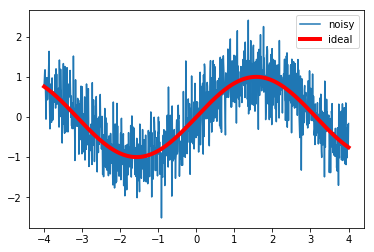

In [4]:
x = np.linspace(-4, 4, 1000)
ideal_signal = np.sin(x)
noisy_signal = ideal_signal + np.random.randn(ideal_signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, ideal_signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0);

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
denoised_signal = convolve(noisy_signal, [0.2]*5, mode='valid')

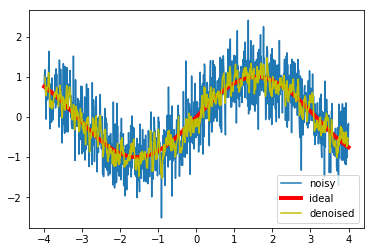

In [6]:
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, ideal_signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0);

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

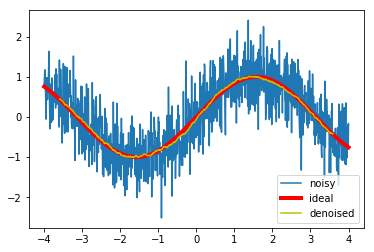

In [7]:
wndlen = 103
custom_denoised_signal = convolve(noisy_signal, [1 / wndlen] * wndlen, mode='valid')

plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, ideal_signal, 'r', label='ideal', linewidth=4)
plt.plot(x[wndlen//2:-(wndlen//2)], custom_denoised_signal, 'y', label='denoised')
plt.legend(loc=0);

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [8]:
rgba_image = plt.imread('lena.gif')
rgb_image = rgba_image[:,:,:-1]

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [9]:
color_to_bw = np.array([0.299, 0.587, 0.114], dtype=float)[::-1].reshape(1, 1, 3)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

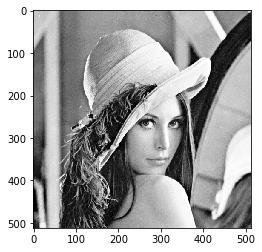

In [10]:
bw_image = convolve(rgb_image, color_to_bw, mode='valid')[:,:,0]
plt.imshow(bw_image, cmap=plt.cm.Greys_r);

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

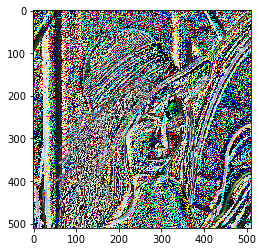

In [11]:
#sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)
#sobel = 0.5 * (sobel_y.T + sobel_y).reshape(3, 3, 1)

sobel = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]], dtype=float).reshape(3, 3, 1)
edge_enhanced_image = convolve(rgb_image, sobel, mode='valid').astype(np.uint8)
plt.imshow(edge_enhanced_image);

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [12]:
def t_convolve_bank(signal, kernels):
    # signal.shape = (sy, sx, n_layers)
    # kernels.shape = (n_filters, ky, kx, n_layers)
    assert signal.ndim == kernels.ndim - 1
    
    conv = np.zeros(signal.shape[:-1] + (kernels.shape[0],), signal.dtype)
    for i in range(kernels.shape[0]):
        conv[:, :, i] = convolve(signal, kernels[i, ::-1, ::-1], mode='valid')[:,:,0]
    return conv

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [13]:
rgb_swap_filter_bank = np.identity(3).reshape(3, 1, 1, 3)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

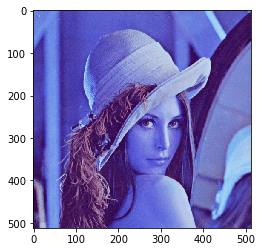

In [14]:
bgr_image = t_convolve_bank(rgb_image, rgb_swap_filter_bank)
plt.imshow(bgr_image);
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [15]:
def funcpool(image, func, pool):
    assert image.ndim == 3
    assert len(pool) == 2
    assert image.shape[0] % pool[0] == 0 and image.shape[1] % pool[1] == 0

    reduced_shape = (image.shape[0] // pool[0], image.shape[1] // pool[1], image.shape[2]) 
    reduced = np.zeros(reduced_shape, image.dtype)
    for i in range(reduced_shape[0]):
        for j in range(reduced_shape[1]):
            reduced[i, j] = func(image[i*pool[0]:(i+1)*pool[0], j*pool[1]:(j+1)*pool[1]], axis=(0, 1))
    return reduced

def maxpool(image, pool = (2,2)):
    return funcpool(image, np.amax, pool)
    
def medianpool(image, pool = (2,2)):
    return funcpool(image, np.median, pool)

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

NOTE: MaxPool fails to eliminate white pixels of noise. In fact, per channel Max Pool adds noise here.


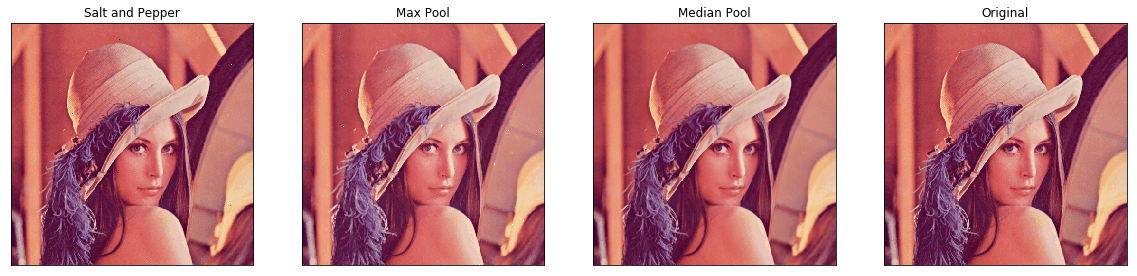

In [16]:
def mixin_dots(img, color):
    assert len(color) == img.shape[-1]
    
    ch_color = np.array(color, dtype = np.uint8)
    rand_idx = lambda size, p: np.random.choice(size, int(size * p)) 
    y, x = rand_idx(rgb_image.shape[0], 0.05), rand_idx(rgb_image.shape[1], 0.1)
    
    for i in range(min(len(y), len(x))):
        img[y[i],x[i]] = ch_color

def get_spnoised(img):
    assert img.ndim == 3
    noized = img.copy()
    mixin_dots(noized, [255] * 3)
    mixin_dots(noized, [0] * 3)
    return noized

spnoised_image = get_spnoised(rgb_image)

f, axarr = plt.subplots(1, 4, figsize=(20, 10))
for ax in f.axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

axarr[0].imshow(spnoised_image)
axarr[0].set_title('Salt and Pepper')

axarr[1].imshow(maxpool(spnoised_image))
axarr[1].set_title('Max Pool')

axarr[2].imshow(medianpool(spnoised_image))
axarr[2].set_title('Median Pool')

axarr[3].imshow(rgb_image)
axarr[3].set_title('Original')

print('NOTE: MaxPool fails to eliminate white pixels of noise. In fact, per channel Max Pool adds noise here.')

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST

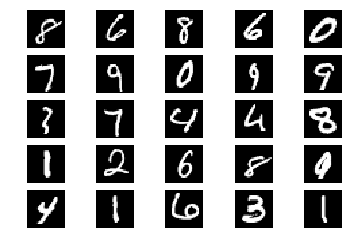

In [17]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')
    
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [18]:
# пример сверточной сети
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, channels, (3, 3), padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [19]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[:batch_size])
y = Variable(labels_train[:batch_size], requires_grad=False)
output = network.forward(X)

In [20]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print('Current loss:', loss.data[0])

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 10.408697128295898


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [36]:
def append_conv3x3(layers, n, kernel_size = (3, 3)):
    for _ in range(n):
        layers.append(nn.Conv2d(channels, channels, kernel_size, padding=1))

        
class FirstConvNet(nn.Module):
    def __init__(self):
        super(FirstConvNet, self).__init__()
        self.arch = "8conv3x3->ReLU->maxpool->16conv3x3->ReLU->ravel->linear->softmax"
        
        # convolution-related layers
        conv_layers = []
        append_conv3x3(conv_layers, 8)
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.MaxPool2d(2))
        append_conv3x3(conv_layers, 16)
        conv_layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*conv_layers)
        
        # linear-related layers
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2, 10), nn.LogSoftmax())

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
class SecondConvNet(nn.Module):
    def __init__(self):
        super(SecondConvNet, self).__init__()
        self.arch = "8conv3x3->ReLU->16conv3x3->ReLU->maxpool->32conv3x3->ravel->linear->softmax"
        
        # convolution-related layers
        conv_layers = []
        append_conv3x3(conv_layers, 8)
        conv_layers.append(nn.ReLU())
        
        append_conv3x3(conv_layers, 32)
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.MaxPool2d(2))
        
        append_conv3x3(conv_layers, 32)
        
        self.conv_layers = nn.Sequential(*conv_layers)
        
        # linear-related layers
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2, 10), nn.LogSoftmax())

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
def optimize(network, batch_size = 10, max_epoch = 50, loss_fn = torch.nn.NLLLoss(), min_test_batches = 64):
    # test_batches -- split err calculation to avoid 
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    err = float('inf')
    errors = []
    for epoch in range(max_epoch):
        # optimize
        for off in range(0, images_train.size(0), batch_size):
            if off % (128 * batch_size) == 0:
                print('\r[epoch', epoch, '] fed to network', off, images_train.size(0), end=' ')
            optimizer.zero_grad()
            X = Variable(images_train[off:off + batch_size])
            y = Variable(labels_train[off:off + batch_size], requires_grad=False)    

            # forward pass
            output = network.forward(X)

            # back-prop
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

        # check error
        new_err, new_out = 0.0, []
        test_batch_size = images_test.size(0) // min_test_batches
        for off in range(0, images_test.size(0), test_batch_size):
            print('\r[', epoch, '] loss caculated', off, images_train.size(0), end=' ')
            X = Variable(images_test[off:off + test_batch_size])
            y = Variable(labels_test[off:off + test_batch_size], requires_grad=False)    
            output = network.forward(X)
            new_out.append(output.data.numpy())
            new_err += loss_fn(output, y).data[0]

        err, out = new_err, new_out
        errors.append(new_err)
    plt.plot(errors)
    plt.show()
    
    np_errors = np.array(errors)
    best_error_at = np.argmax(np_errors)
    print('\rBest iteration is', best_error_at, 'with error', np_errors[best_error_at])
    return np.stack(out, axis=0)

Первая архитектура:

In [ ]:
first_output = optimize(FirstConvNet(), 10)

[epoch 3 ] fed to network 14080 52500 

Вторая архитектура:

In [ ]:
second_output = optimize(SecondConvNet(), 10)

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [ ]:
##### YOUR CODE HERE #####

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [ ]:
##### YOUR CODE HERE #####

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: